In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit

RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

In [2]:
# read data again
df = pd.read_csv("data/raw/Life Expectancy Data.csv")
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# clean column name
df = df.copy()
df.columns = (df.columns
              .str.strip()
              .str.replace(' ','_', regex=False)
              .str.replace('-','_', regex=False)
              .str.replace(r'_+', '_', regex=True)  # replace multiple underscores with single
              .str.lower())

target = "life_expectancy"
group_col = "country"
time_col  = "year"

print(list(df.columns))
df[[target, group_col, time_col]].head()

['country', 'year', 'status', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling']


,life_expectancy,country,year
0,65.0,Afghanistan,2015
1,59.9,Afghanistan,2014
2,59.9,Afghanistan,2013
3,59.5,Afghanistan,2012
4,59.2,Afghanistan,2011


In [4]:
# missing overview
print("Shape:", df.shape)
missing_ratio = df.isna().mean().sort_values(ascending=False)
display(missing_ratio.head(12))

Shape: (2938, 22)


population                         0.221920
hepatitis_b                        0.188223
gdp                                0.152485
total_expenditure                  0.076923
alcohol                            0.066031
income_composition_of_resources    0.056841
schooling                          0.055480
thinness_5_9_years                 0.011572
thinness_1_19_years                0.011572
bmi                                0.011572
polio                              0.006467
diphtheria                         0.006467
dtype: float64

In [5]:
# remove rows with missing target values
df_clean = df.dropna(subset=[target]).copy()
print(f"Dropped {len(df) - len(df_clean)} rows with missing target")
print(f"Remaining: {len(df_clean)} rows")

# split target and X
y = df_clean[target]
X = df_clean.drop(columns=[target])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# remove time and group from features
if group_col in num_cols:
    num_cols.remove(group_col)
if time_col in num_cols:
    num_cols.remove(time_col)
if group_col in cat_cols:
    cat_cols.remove(group_col)
if time_col in cat_cols:
    cat_cols.remove(time_col)

print("Numeric cols:", len(num_cols), num_cols)
print("Categorical cols:", cat_cols)

Dropped 10 rows with missing target
Remaining: 2928 rows
Numeric cols: 18 ['adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling']
Categorical cols: ['status']


In [6]:
# log transform
log_cols = [    # determine in eda, right skewed
    "gdp",
    "population",
    "percentage_expenditure",
    "measles",
    "hiv/aids",
    "infant_deaths",
    "under_five_deaths"
]

def log1p_selected(X_df):
    X_df = X_df.copy()
    for c in log_cols:
        if c in X_df.columns:
            X_df[c] = np.log1p(X_df[c].astype(float))
    return X_df

log_transformer = FunctionTransformer(log1p_selected, feature_names_out="one-to-one")

In [7]:
# missing value
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # median for skewed features
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    # no imputer needed - status has no missing values
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

In [8]:
# full pipeline
full_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("prep", preprocessor)
])

In [9]:
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import seaborn as sns

print("Modeling libraries imported")

Modeling libraries imported


In [10]:
# use 5 random states for robust evaluation
RANDOM_STATES = [42, 123, 456, 789, 2024]

print(f"Will run the entire pipeline with {len(RANDOM_STATES)} different random states")
print(f"Random states: {RANDOM_STATES}\n")

Will run the entire pipeline with 5 different random states
Random states: [42, 123, 456, 789, 2024]



In [11]:
# unified loop: one split, train all models, evaluate, and store results
all_cv_results = []
all_test_results = []
best_models = {}  # store best models for each random state

for current_state in RANDOM_STATES:
    print(f"\n{'='*70}")
    print(f"RANDOM_STATE = {current_state}")
    print(f"{'='*70}\n")
    
    # STEP 1: split data (only once per random state)
    groups = X[group_col]
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=current_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train = groups.iloc[train_idx]
    
    print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
    overlapping = set(groups.iloc[train_idx]) & set(groups.iloc[test_idx])
    print(f"Overlapping countries: {overlapping}\n")
    
    gkf = GroupKFold(n_splits=5)
    
    # STEP 2: cross-validation for baseline models
    print("Cross-Validation for baseline models...")
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=current_state),
        'Lasso': Lasso(random_state=current_state),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=current_state, n_jobs=-1),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=current_state, n_jobs=-1)
    }
    
    for name, model in models.items():
        model_pipe = Pipeline(steps=[
            ('preprocessing', full_pipeline), 
            ('model', model)
        ])
        
        cv_scores = cross_validate(
            model_pipe, 
            X_train, 
            y_train, 
            groups=groups_train, 
            cv=gkf, 
            scoring=['neg_root_mean_squared_error', 'r2']
        )
        
        rmse_scores = -cv_scores['test_neg_root_mean_squared_error']
        r2_scores = cv_scores['test_r2']
        
        all_cv_results.append({
            'Random_State': current_state,
            'Model': name,
            'CV_RMSE_Mean': rmse_scores.mean(),
            'CV_RMSE_Std': rmse_scores.std(),
            'CV_R2_Mean': r2_scores.mean(),
            'CV_R2_Std': r2_scores.std()
        })
        
        print(f"  {name:20s} CV RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
    
    # STEP 3: hyperparameter tuning for Ridge
    print("\nHyperparameter tuning for Ridge...")
    
    param_grid_ridge = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    ridge_tune_pipe = Pipeline(steps=[
        ('preprocessing', full_pipeline),
        ('model', Ridge(random_state=current_state))
    ])
    
    ridge_grid = GridSearchCV(
        ridge_tune_pipe,
        param_grid_ridge,
        cv=gkf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    ridge_grid.fit(X_train, y_train, groups=groups_train)
    ridge_best_cv_rmse = -ridge_grid.best_score_
    
    print(f"  Best Ridge params: {ridge_grid.best_params_}")
    print(f"  Best Ridge CV RMSE: {ridge_best_cv_rmse:.4f}")
    
    # STEP 4: hyperparameter tuning for Lasso
    print("\nHyperparameter tuning for Lasso...")
    
    param_grid_lasso = {
        'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
    
    lasso_tune_pipe = Pipeline(steps=[
        ('preprocessing', full_pipeline),
        ('model', Lasso(random_state=current_state, max_iter=10000))
    ])
    
    lasso_grid = GridSearchCV(
        lasso_tune_pipe,
        param_grid_lasso,
        cv=gkf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    lasso_grid.fit(X_train, y_train, groups=groups_train)
    lasso_best_cv_rmse = -lasso_grid.best_score_
    
    print(f"  Best Lasso params: {lasso_grid.best_params_}")
    print(f"  Best Lasso CV RMSE: {lasso_best_cv_rmse:.4f}")
    
    # STEP 5: hyperparameter tuning for Random Forest
    print("\nHyperparameter tuning for Random Forest...")
    
    param_grid_rf = {
        'model__n_estimators': [200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_leaf': [1, 4],
        'model__max_features': ['sqrt', 1.0]
    }
    
    rf_tune_pipe = Pipeline(steps=[
        ('preprocessing', full_pipeline),
        ('model', RandomForestRegressor(random_state=current_state, n_jobs=-1))
    ])
    
    rf_grid = GridSearchCV(
        rf_tune_pipe,
        param_grid_rf,
        cv=gkf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    rf_grid.fit(X_train, y_train, groups=groups_train)
    rf_best_cv_rmse = -rf_grid.best_score_
    
    print(f"  Best RF params: {rf_grid.best_params_}")
    print(f"  Best RF CV RMSE: {rf_best_cv_rmse:.4f}")
    
    # STEP 6: hyperparameter tuning for XGBoost
    print("\nHyperparameter tuning for XGBoost...")
    
    param_grid_xgb = {
        'model__n_estimators': [500],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3],
        'model__subsample': [0.7],
        'model__colsample_bytree': [0.7]
    }
    
    xgb_tune_pipe = Pipeline(steps=[
        ('preprocessing', full_pipeline),
        ('model', XGBRegressor(random_state=current_state, n_jobs=-1))
    ])
    
    xgb_grid = GridSearchCV(
        xgb_tune_pipe,
        param_grid_xgb,
        cv=gkf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    xgb_grid.fit(X_train, y_train, groups=groups_train)
    xgb_best_cv_rmse = -xgb_grid.best_score_
    
    print(f"  Best XGB params: {xgb_grid.best_params_}")
    print(f"  Best XGB CV RMSE: {xgb_best_cv_rmse:.4f}")
    
    # STEP 7: test set evaluation
    print("\nTest set evaluation...")
    
    # baseline
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_train[[]], y_train)
    y_pred_dummy = dummy.predict(X_test[[]])
    rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
    r2_baseline = r2_score(y_test, y_pred_dummy)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'Baseline (Mean)',
        'Test_RMSE': rmse_baseline,
        'Test_R2': r2_baseline,
        'CV_RMSE': np.nan
    })
    
    # linear regression (no tuning needed)
    lr_pipe = Pipeline(steps=[('preprocessing', full_pipeline), ('model', LinearRegression())])
    lr_pipe.fit(X_train, y_train)
    y_pred_lr = lr_pipe.predict(X_test)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    r2_lr = r2_score(y_test, y_pred_lr)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'Linear Regression',
        'Test_RMSE': rmse_lr,
        'Test_R2': r2_lr,
        'CV_RMSE': np.nan
    })
    
    # ridge (tuned)
    ridge_best = ridge_grid.best_estimator_
    y_pred_ridge = ridge_best.predict(X_test)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'Ridge',
        'Test_RMSE': rmse_ridge,
        'Test_R2': r2_ridge,
        'CV_RMSE': ridge_best_cv_rmse
    })
    
    # lasso (tuned)
    lasso_best = lasso_grid.best_estimator_
    y_pred_lasso = lasso_best.predict(X_test)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'Lasso',
        'Test_RMSE': rmse_lasso,
        'Test_R2': r2_lasso,
        'CV_RMSE': lasso_best_cv_rmse
    })
    
    # random forest (tuned)
    rf_best = rf_grid.best_estimator_
    y_pred_rf = rf_best.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'Random Forest',
        'Test_RMSE': rmse_rf,
        'Test_R2': r2_rf,
        'CV_RMSE': rf_best_cv_rmse
    })
    
    # xgboost (tuned)
    xgb_best = xgb_grid.best_estimator_
    y_pred_xgb = xgb_best.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    all_test_results.append({
        'Random_State': current_state,
        'Model': 'XGBoost',
        'Test_RMSE': rmse_xgb,
        'Test_R2': r2_xgb,
        'CV_RMSE': xgb_best_cv_rmse
    })
    
    # store best models for later visualization
    best_models[current_state] = {
        'ridge_best': ridge_best,
        'lasso_best': lasso_best,
        'rf_best': rf_best,
        'xgb_best': xgb_best,
        'X_test': X_test,
        'y_test': y_test,
        'predictions': {
            'lr': y_pred_lr,
            'ridge': y_pred_ridge,
            'lasso': y_pred_lasso,
            'rf': y_pred_rf,
            'xgb': y_pred_xgb
        },
        'metrics': {
            'lr': {'rmse': rmse_lr, 'r2': r2_lr},
            'ridge': {'rmse': rmse_ridge, 'r2': r2_ridge},
            'lasso': {'rmse': rmse_lasso, 'r2': r2_lasso},
            'rf': {'rmse': rmse_rf, 'r2': r2_rf},
            'xgb': {'rmse': rmse_xgb, 'r2': r2_xgb}
        }
    }
    
    print(f"  Baseline:          Test RMSE = {rmse_baseline:.4f}")
    print(f"  Linear Regression: Test RMSE = {rmse_lr:.4f}")
    print(f"  Ridge:             Test RMSE = {rmse_ridge:.4f}, CV RMSE = {ridge_best_cv_rmse:.4f}")
    print(f"  Lasso:             Test RMSE = {rmse_lasso:.4f}, CV RMSE = {lasso_best_cv_rmse:.4f}")
    print(f"  Random Forest:     Test RMSE = {rmse_rf:.4f}, CV RMSE = {rf_best_cv_rmse:.4f}")
    print(f"  XGBoost:           Test RMSE = {rmse_xgb:.4f}, CV RMSE = {xgb_best_cv_rmse:.4f}")

print(f"\n{'='*70}")
print("ALL RANDOM STATES COMPLETED")
print(f"{'='*70}\n")


RANDOM_STATE = 42

Train set: (2336, 21), Test set: (592, 21)
Overlapping countries: set()

Cross-Validation for baseline models...
  Linear Regression    CV RMSE: 3.8230 (+/- 0.5059)
  Ridge                CV RMSE: 3.8244 (+/- 0.5051)
  Lasso                CV RMSE: 4.1352 (+/- 0.4424)
  Random Forest        CV RMSE: 2.9598 (+/- 0.2472)
  XGBoost              CV RMSE: 3.0111 (+/- 0.2308)

Hyperparameter tuning for Ridge...
  Best Ridge params: {'model__alpha': 0.1}
  Best Ridge CV RMSE: 3.8230

Hyperparameter tuning for Lasso...
  Best Lasso params: {'model__alpha': 0.001}
  Best Lasso CV RMSE: 3.8230

Hyperparameter tuning for Random Forest...
  Best RF params: {'model__max_depth': None, 'model__max_features': 1.0, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
  Best RF CV RMSE: 2.9602

Hyperparameter tuning for XGBoost...
  Best XGB params: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estim

CROSS-VALIDATION RESULTS SUMMARY

CV Performance (averaged over all random states):


,Model,CV_RMSE_Mean_mean,CV_RMSE_Mean_std,CV_RMSE_Mean_min,CV_RMSE_Mean_max,CV_R2_Mean_mean,CV_R2_Mean_std,CV_R2_Mean_min,CV_R2_Mean_max
4,XGBoost,3.0921,0.0644,3.0111,3.1711,0.8883,0.0047,0.8830,0.8944
2,Random Forest,3.1497,0.1586,2.9598,3.3170,0.8835,0.0109,0.8712,0.8984
3,Ridge,3.7582,0.0501,3.7002,3.8244,0.8336,0.0037,0.8299,0.8392
1,Linear Regression,3.7588,0.0494,3.7006,3.8230,0.8336,0.0037,0.8300,0.8393
0,Lasso,4.0745,0.0700,4.0066,4.1596,0.8037,0.0059,0.7971,0.8112


/var/folders/5n/fck56_810ts1y0zzgsh4252h0000gn/T/ipykernel_6995/38878258.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_cv_df, x='Model', y='CV_RMSE_Mean', order=models_order, palette='Set2')


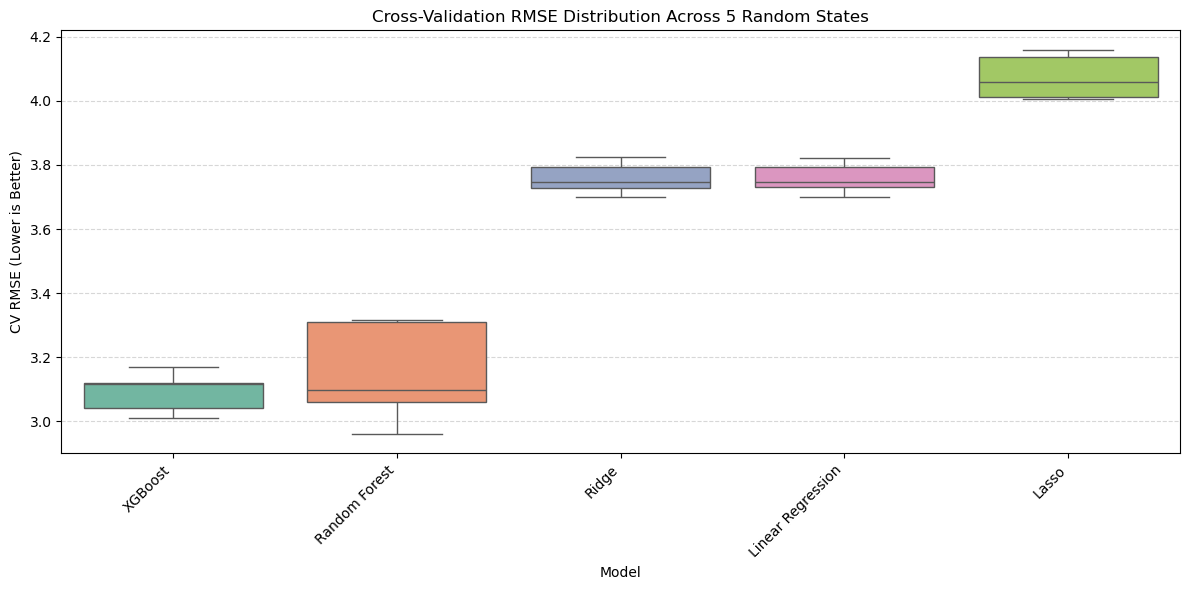

Figure saved to: reports/figures/cv_rmse_distribution.png

Detailed CV results by random state:


,Random_State,Model,CV_RMSE_Mean,CV_RMSE_Std,CV_R2_Mean,CV_R2_Std
2,42,Lasso,4.135202,0.442360,0.800125,0.040328
7,123,Lasso,4.006609,0.771876,0.808542,0.058921
12,456,Lasso,4.012818,0.390572,0.801610,0.052293
17,789,Lasso,4.058298,0.594915,0.811155,0.056947
22,2024,Lasso,4.159638,0.524922,0.797150,0.040247
0,42,Linear Regression,3.822997,0.505932,0.830009,0.036459
5,123,Linear Regression,3.730133,0.492581,0.835154,0.037622
10,456,Linear Regression,3.700577,0.299409,0.831946,0.038236
15,789,Linear Regression,3.745767,0.559913,0.839311,0.047738
20,2024,Linear Regression,3.794382,0.401607,0.831542,0.026359


In [12]:
# cross validation result summary

all_cv_df = pd.DataFrame(all_cv_results)

print("="*70)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*70 + "\n")

cv_summary = all_cv_df.groupby('Model').agg({
    'CV_RMSE_Mean': ['mean', 'std', 'min', 'max'],
    'CV_R2_Mean': ['mean', 'std', 'min', 'max']
}).round(4)

cv_summary.columns = ['_'.join(col).strip() for col in cv_summary.columns.values]
cv_summary = cv_summary.reset_index()

print("CV Performance (averaged over all random states):")
display(cv_summary.sort_values('CV_RMSE_Mean_mean'))

# visualization
plt.figure(figsize=(12, 6))
models_order = all_cv_df.groupby('Model')['CV_RMSE_Mean'].mean().sort_values().index
sns.boxplot(data=all_cv_df, x='Model', y='CV_RMSE_Mean', order=models_order, palette='Set2')
plt.title(f'Cross-Validation RMSE Distribution Across {len(RANDOM_STATES)} Random States')
plt.ylabel('CV RMSE (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('reports/figures/cv_rmse_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: reports/figures/cv_rmse_distribution.png")

print("\nDetailed CV results by random state:")
display(all_cv_df.sort_values(['Model', 'Random_State']))

TEST SET EVALUATION SUMMARY

Test Performance (averaged over all random states):


,Model,Test_RMSE_mean,Test_RMSE_std,Test_RMSE_min,Test_RMSE_max,Test_R2_mean,Test_R2_std,Test_R2_min,Test_R2_max,CV_RMSE_mean,CV_RMSE_std
5,XGBoost,2.7276,0.2780,2.4115,3.1452,0.9225,0.0146,0.9018,0.9419,2.8713,0.0681
3,Random Forest,3.0685,0.3302,2.8313,3.6348,0.9019,0.0196,0.8688,0.9200,3.0732,0.0703
1,Lasso,3.7787,0.2889,3.4371,4.0958,0.8514,0.0227,0.8311,0.8820,3.7586,0.0496
4,Ridge,3.7795,0.2869,3.4384,4.0914,0.8513,0.0226,0.8315,0.8820,3.7577,0.0497
2,Linear Regression,3.7804,0.2878,3.4379,4.0989,0.8512,0.0227,0.8309,0.8820,NaN,NaN
0,Baseline (Mean),10.0109,0.3281,9.5187,10.4102,-0.0375,0.0373,-0.0909,-0.0000,NaN,NaN


/var/folders/5n/fck56_810ts1y0zzgsh4252h0000gn/T/ipykernel_6995/560143224.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_test_df, x='Model', y='Test_RMSE', order=models_order, palette='Set3')


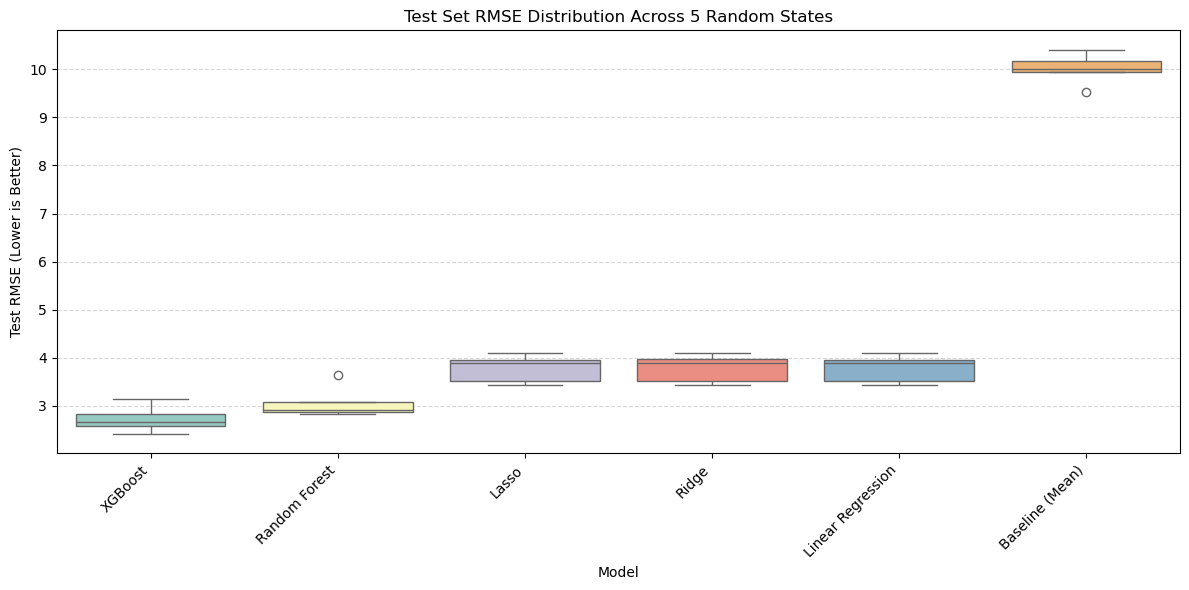

Figure saved to: reports/figures/test_rmse_distribution.png

Improvement over baseline (average across 5 random states):
  Linear Regression   :  62.24%
  Ridge               :  62.25%
  Lasso               :  62.25%
  Random Forest       :  69.35%
  XGBoost             :  72.75%

Detailed test results by random state:


,Random_State,Model,Test_RMSE,Test_R2,CV_RMSE
0,42,Baseline (Mean),9.948670,-0.059335,NaN
6,123,Baseline (Mean),10.410163,-0.090879,NaN
12,456,Baseline (Mean),10.169392,-0.026764,NaN
18,789,Baseline (Mean),9.518720,-0.010737,NaN
24,2024,Baseline (Mean),10.007643,-0.000017,NaN
3,42,Lasso,3.512204,0.867973,3.823019
9,123,Lasso,4.095846,0.831131,3.729689
15,456,Lasso,3.964364,0.843963,3.700343
21,789,Lasso,3.883985,0.831719,3.745448
27,2024,Lasso,3.437142,0.882039,3.794357


In [13]:
# test set result summary

all_test_df = pd.DataFrame(all_test_results)

print("="*70)
print("TEST SET EVALUATION SUMMARY")
print("="*70 + "\n")

test_summary = all_test_df.groupby('Model').agg({
    'Test_RMSE': ['mean', 'std', 'min', 'max'],
    'Test_R2': ['mean', 'std', 'min', 'max'],
    'CV_RMSE': ['mean', 'std']
}).round(4)

test_summary.columns = ['_'.join(col).strip() for col in test_summary.columns.values]
test_summary = test_summary.reset_index()

print("Test Performance (averaged over all random states):")
display(test_summary.sort_values('Test_RMSE_mean'))

# visualization
plt.figure(figsize=(12, 6))
models_order = all_test_df.groupby('Model')['Test_RMSE'].mean().sort_values().index
sns.boxplot(data=all_test_df, x='Model', y='Test_RMSE', order=models_order, palette='Set3')
plt.title(f'Test Set RMSE Distribution Across {len(RANDOM_STATES)} Random States')
plt.ylabel('Test RMSE (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('reports/figures/test_rmse_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: reports/figures/test_rmse_distribution.png")

# improvement over baseline
baseline_mean = all_test_df[all_test_df['Model'] == 'Baseline (Mean)']['Test_RMSE'].mean()
print(f"\nImprovement over baseline (average across {len(RANDOM_STATES)} random states):")
for model in ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost']:
    model_mean = all_test_df[all_test_df['Model'] == model]['Test_RMSE'].mean()
    improvement = (baseline_mean - model_mean) / baseline_mean * 100
    print(f"  {model:20s}: {improvement:6.2f}%")

print("\nDetailed test results by random state:")
display(all_test_df.sort_values(['Model', 'Random_State']))

Showing prediction plots for RANDOM_STATE = 2024



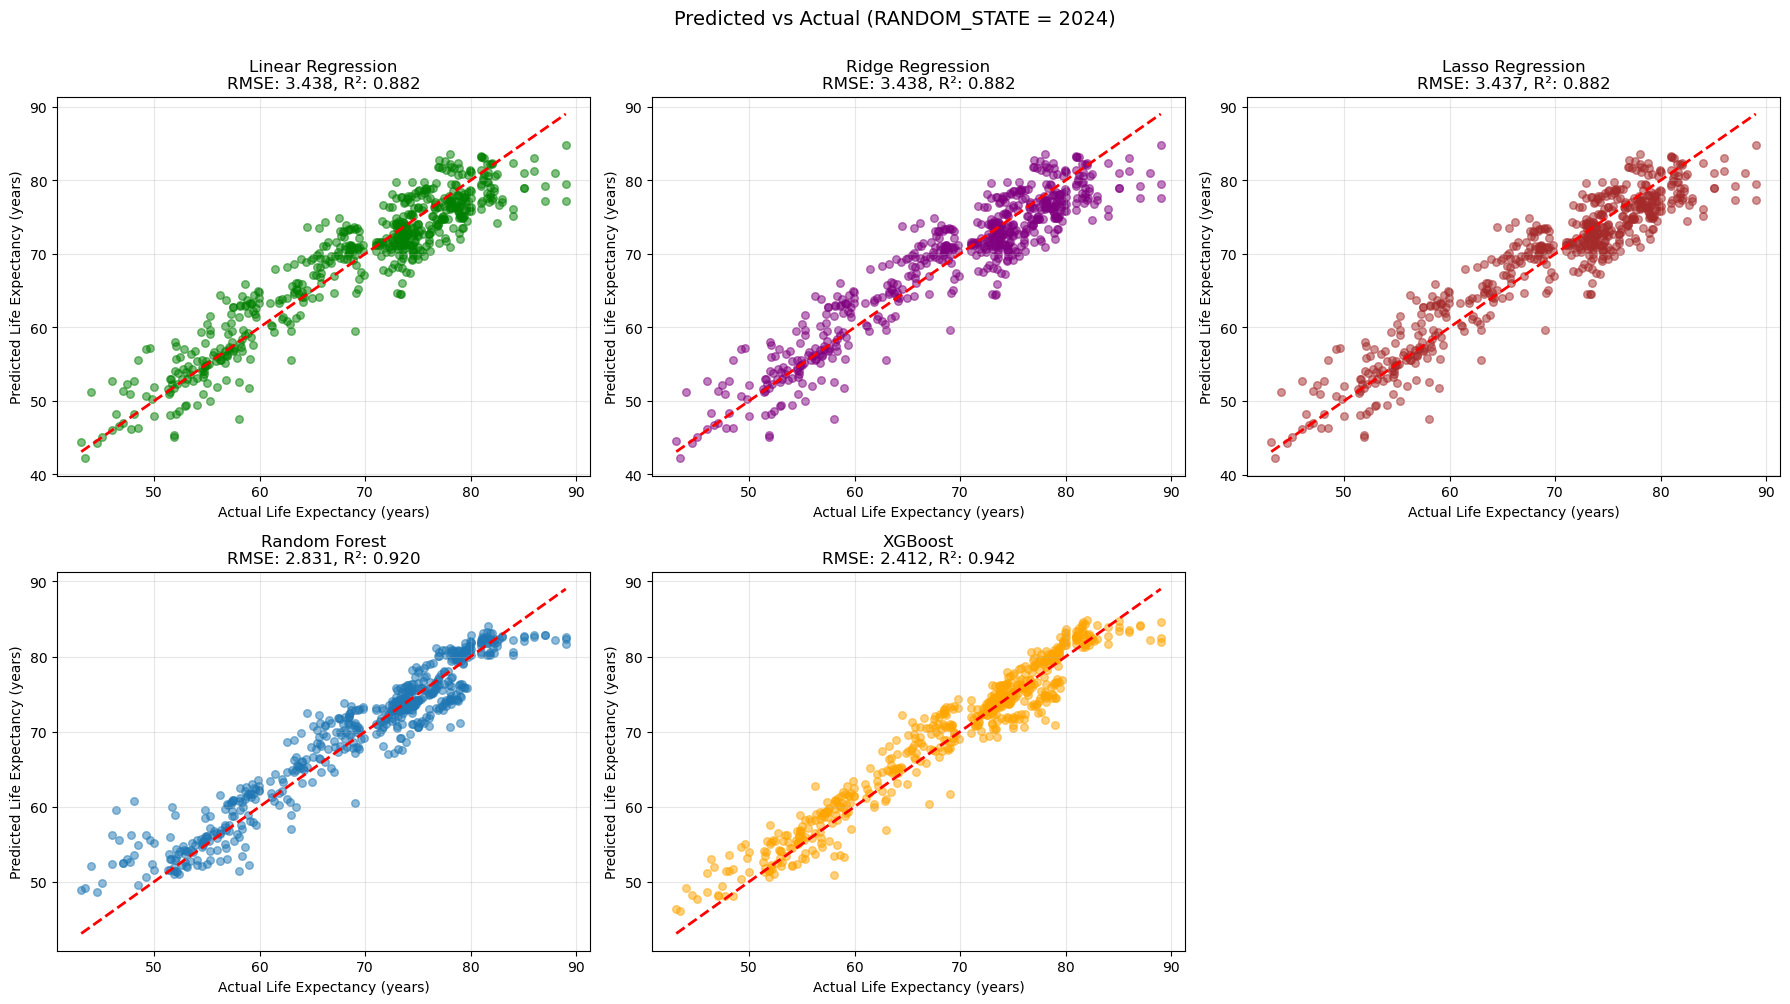

Figure saved to: reports/figures/predicted_vs_actual.png


In [14]:
# predicted and actual scatterplot (use one seed)

example_state = RANDOM_STATES[-1]
print(f"Showing prediction plots for RANDOM_STATE = {example_state}\n")

example_data = best_models[example_state]
y_test = example_data['y_test']
preds = example_data['predictions']
metrics = example_data['metrics']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# linear regression
axes[0, 0].scatter(y_test, preds['lr'], alpha=0.5, s=30, color='green')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Life Expectancy (years)')
axes[0, 0].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 0].set_title(f'Linear Regression\nRMSE: {metrics["lr"]["rmse"]:.3f}, R²: {metrics["lr"]["r2"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# ridge
axes[0, 1].scatter(y_test, preds['ridge'], alpha=0.5, s=30, color='purple')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Life Expectancy (years)')
axes[0, 1].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 1].set_title(f'Ridge Regression\nRMSE: {metrics["ridge"]["rmse"]:.3f}, R²: {metrics["ridge"]["r2"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# lasso
axes[0, 2].scatter(y_test, preds['lasso'], alpha=0.5, s=30, color='brown')
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual Life Expectancy (years)')
axes[0, 2].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 2].set_title(f'Lasso Regression\nRMSE: {metrics["lasso"]["rmse"]:.3f}, R²: {metrics["lasso"]["r2"]:.3f}')
axes[0, 2].grid(True, alpha=0.3)

# random forest
axes[1, 0].scatter(y_test, preds['rf'], alpha=0.5, s=30)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Life Expectancy (years)')
axes[1, 0].set_ylabel('Predicted Life Expectancy (years)')
axes[1, 0].set_title(f'Random Forest\nRMSE: {metrics["rf"]["rmse"]:.3f}, R²: {metrics["rf"]["r2"]:.3f}')
axes[1, 0].grid(True, alpha=0.3)

# xgboost
axes[1, 1].scatter(y_test, preds['xgb'], alpha=0.5, s=30, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Life Expectancy (years)')
axes[1, 1].set_ylabel('Predicted Life Expectancy (years)')
axes[1, 1].set_title(f'XGBoost\nRMSE: {metrics["xgb"]["rmse"]:.3f}, R²: {metrics["xgb"]["r2"]:.3f}')
axes[1, 1].grid(True, alpha=0.3)

# hide the last subplot
axes[1, 2].axis('off')

plt.suptitle(f'Predicted vs Actual (RANDOM_STATE = {example_state})', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('reports/figures/predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: reports/figures/predicted_vs_actual.png")

XGBoost Feature Importance (RANDOM_STATE = 2024)



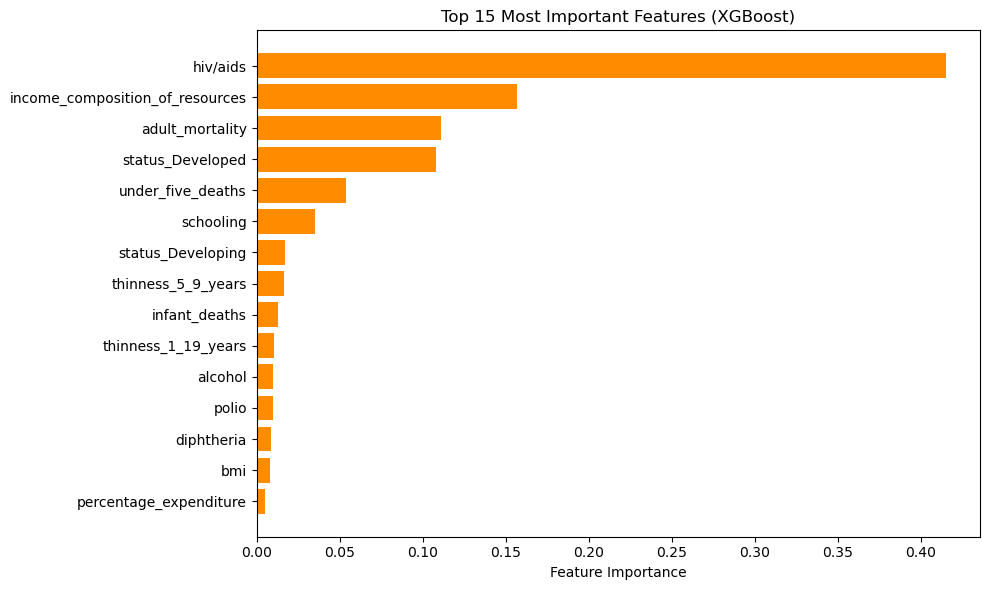

Figure saved to: reports/figures/feature_importance_xgboost.png

Top 10 Most Important Features:


,feature,importance
11,hiv/aids,0.414969
16,income_composition_of_resources,0.156962
0,adult_mortality,0.111215
18,status_Developed,0.108170
7,under_five_deaths,0.053937
17,schooling,0.035101
19,status_Developing,0.016766
15,thinness_5_9_years,0.016409
1,infant_deaths,0.012825
14,thinness_1_19_years,0.010461


In [15]:
# xgboost feature importance (use one seed)

print(f"XGBoost Feature Importance (RANDOM_STATE = {example_state})\n")

xgb_best = best_models[example_state]['xgb_best']

preprocessor_fitted = xgb_best.named_steps['preprocessing']
feature_names = preprocessor_fitted.get_feature_names_out()

xgb_model = xgb_best.named_steps['model']
xgb_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_importances
}).sort_values('importance', ascending=False)

# clean name format
importance_df['feature'] = importance_df['feature'].str.replace('num__', '').str.replace('cat__', '')

# plot top 15 features
plt.figure(figsize=(10, 6))
top_n = 15
plt.barh(range(top_n), importance_df['importance'].head(top_n), color='darkorange')
plt.yticks(range(top_n), importance_df['feature'].head(top_n))
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/figures/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: reports/figures/feature_importance_xgboost.png")

print("\nTop 10 Most Important Features:")
display(importance_df.head(10))